In [1]:
import numpy as np
import matplotlib.pylab as plt
from sparsity_estimators import Adaptive_Lasso_SS, ir_cond,ir_condAL,ir_condrAL
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample, shuffle

import seaborn as sns

from matplotlib import rc, font_manager
from sklearn.linear_model import Ridge
%load_ext autoreload
%autoreload 2

In [2]:
sns.set(font_scale=1.5)
sns.set_style("white")


In [3]:
u     = np.load('deep_learning_based/data/KS_u.npy')
x     = np.load('deep_learning_based/data/KS_x.npy')
t     = np.load('deep_learning_based/data/KS_t.npy')

theta = np.load('../data/KS_thetaN.npy')
dt    = np.load('../data/KS_dtN.npy')


theta = np.array(theta,dtype=np.float64)
dt = np.array(dt,dtype=np.float64)


<ipython-input-3-847b6348be84>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  theta = np.array(theta,dtype=np.float64)
<ipython-input-3-847b6348be84>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  dt = np.array(dt,dtype=np.float64)


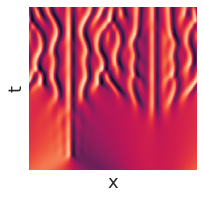

In [4]:

plt.figure(figsize=(3,3))
ax = sns.heatmap(u.reshape(len(x),len(t)).T,cbar=False)


ax.invert_yaxis()
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('x')
ax.set_ylabel('t');


In [5]:
theta.shape[0]

207624

In [6]:
theta, dt = shuffle(theta, dt, random_state=0)

In [7]:
GT = [7,12,24]
not_GT = np.setdiff1d(np.arange(0,theta.shape[1]),np.array(GT)).tolist()

In [8]:
theta.shape

(207624, 36)

In [9]:
mLasso = ir_cond(theta,GT)
mLasso[1].max()

1.3780560681563732

In [10]:
mAdaLasso =ir_condAL(theta,dt,GT)
mAdaLasso[1].max()

1.7567279944614738

In [11]:
width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 18,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
}

plt.rcParams.update(tex_fonts)

# Randomization effect

In [12]:
n_samples = 1000



l_tau = []
l_alphas = []

l_tauR = []
l_alphasR = []

for seed in range(1):


    idx = sample_without_replacement(n_population=theta.shape[0]-1, n_samples=n_samples, random_state=seed)
    X = theta[idx]
    y = dt[idx]

    normed_theta = X/np.linalg.norm(theta,axis=0,keepdims=True)
    normed_dt = y/np.linalg.norm(dt,axis=0,keepdims=True)


    xi, for_plots = Adaptive_Lasso_SS(normed_theta,normed_dt,n_alphas=20,nI=100,eps=4,randomized = False)
    [tau,piT,pSE,alphas, minLambdaSS, active_set,region] = for_plots
    l_tau.append(tau)
    l_alphas.append(alphas)

    xiR, for_plotsR = Adaptive_Lasso_SS(normed_theta,normed_dt,n_alphas=20,nI=100,eps=4,randomized = True)
    [tauR,piTR,pSER,alphasR, minLambdaSSR, active_setR,regionR] = for_plotsR
    l_tauR.append(tauR)
    l_alphasR.append(alphasR)


m_tau    = np.array(l_tau)
m_alphas = np.array(l_alphas)

m_tauR    = np.array(l_tauR)
m_alphasR = np.array(l_alphasR)

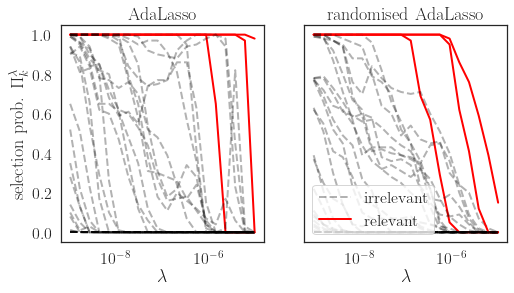

In [13]:
fig,ax = plt.subplots(1,2,sharex='row',sharey='row',figsize=(8,4))

i=0
for term in range(theta.shape[1]):
    meanL = m_tau.mean(axis=0)
    stdL  = m_tau.std(axis=0)
    
    if term in GT:
        alpha = 1
        ln_style='-'
        colorr = 'red'
        lab = 'relevant'

    else:
        alpha=0.3
        ln_style='--'
        colorr = 'black'
        lab = 'irrelevant'
        
    ax[i].plot(m_alphas[0,:],meanL[:,term],linestyle=ln_style,color=colorr,linewidth=2,alpha=alpha,label=lab)        
    #ax[i].fill_between(m_alphas[0,:],meanL[:,term]-0.2*stdL[:,term],meanL[:,term]+0.2*stdL[:,term],alpha=alpha)
    ax[i].set_xscale('log')
ax[i].set_xlabel(r'$\lambda$')#, fontsize=font_size)
ax[0].set_ylabel(r'selection prob. $\Pi_{k}^{\lambda}$')

i=1
for term in range(theta.shape[1]):
    meanL = m_tauR.mean(axis=0)
    stdL  = m_tauR.std(axis=0)
    
    if term in GT:
        alpha = 1
        ln_style='-'
        colorr = 'red'
        lab = 'relevant'

    else:
        alpha=0.3
        ln_style='--'
        colorr = 'black'
        lab = 'irrelevant'

    ax[i].plot(m_alphasR[0,:],meanL[:,term],linestyle=ln_style,color=colorr,linewidth=2,alpha=alpha,label=lab)        
    #ax[i].fill_between(m_alphasR[0,:],meanL[:,term]-0.2*stdL[:,term],meanL[:,term]+0.2*stdL[:,term],alpha=alpha)
    ax[i].set_xscale('log')
ax[i].set_xlabel(r'$\lambda$')#, fontsize=font_size)
ax[0].set_ylabel(r'selection prob. $\Pi_{k}^{\lambda}$')

ax[0].set_title('AdaLasso')#, fontsize=font_size)
ax[1].set_title('randomised AdaLasso')#, fontsize=font_size)



cx = ax[0].get_legend_handles_labels()
plt.legend([cx[0][not_GT[0]],cx[0][GT[0]]],[cx[1][not_GT[0]],cx[1][GT[0]]],loc='lower left')

plt.savefig("figures/randomization_effect.pdf", bbox_inches='tight')

## with error control

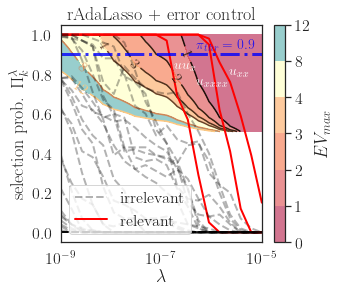

In [52]:
fig,ax = plt.subplots(1,1,sharex='row',sharey='row',figsize=(4.5,4))

for term in range(theta.shape[1]):
    meanL = m_tauR.mean(axis=0)
    stdL  = m_tauR.std(axis=0)
    
    if term in GT:
        alpha = 1
        ln_style='-'
        colorr = 'red'
        lab = 'relevant'

    else:
        alpha=0.3
        ln_style='--'
        colorr = 'black'
        lab = 'irrelevant'
        
    ax.plot(m_alphasR[0,:],meanL[:,term],linestyle=ln_style,color=colorr,linewidth=2,alpha=alpha,label=lab)        
    ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$')#, fontsize=font_size)
ax.set_ylabel(r'selection prob. $\Pi_{k}^{\lambda}$')


tau=tauR
alphas=alphasR

cx = ax.get_legend_handles_labels()
plt.legend([cx[0][not_GT[0]],cx[0][GT[0]]],[cx[1][not_GT[0]],cx[1][GT[0]]],loc='lower left')
piT = 0.9
efp=3
# average of selected variables
q_hat = tau.sum(axis=1)
# verifying on some upper bound on efp
ev_region = (q_hat)**2/((2*piT-1)*X.shape[1])    
idxS = (ev_region<efp).argmax()   
minLambdaSS = alphas[idxS]
# selecting variables where the efp is respected
active_set = (tau[idxS:,:]>piT).any(axis=0)   
thrs = np.arange(0.51,1,0.001)
E_V_ub = np.stack([(q_hat)**2/((2*piT-1)*36) for piT in thrs])
c=ax.contour(alphas, thrs, E_V_ub,levels=[0,1,2,3,4,8,12],cmap='copper')
cf=ax.contourf(alphas, thrs, E_V_ub,levels=[0,1,2,3,4,8,12],cmap='Spectral',alpha=0.6)
ax.clabel(c, inline=True,fmt='%0.0f', fontsize=15)
d=fig.colorbar(cf, ax=ax)
d.set_label(r'$EV_{max}$')

ax.plot([alphas.min(),alphas.max()],[0.9,0.9],'-.',color='blue',linewidth=3,alpha=0.8)
ax.text(0.5*1e-6,0.93,r'$\pi_{thr}=0.9$',color='blue',alpha=0.8)


ax.text(1.8*1e-7,0.83,r'$uu_x$',color='white')
ax.text(0.5e-6,0.75,r'$u_{xxxx}$',color='white')
ax.text(2.2e-6,0.8,r'$u_{xx}$',color='white')


ax.set_title('rAdaLasso + error control')#, fontsize=font_size)

plt.savefig("figures/error_control.pdf", bbox_inches='tight')

In [53]:
meanL.shape

(20, 36)